# Saving and Loading Models

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',
                                 download=True,
                                 train=True,
                                 transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',
                                 download=True,
                                 train=False,
                                 transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=64,
                                          shuffle=True)

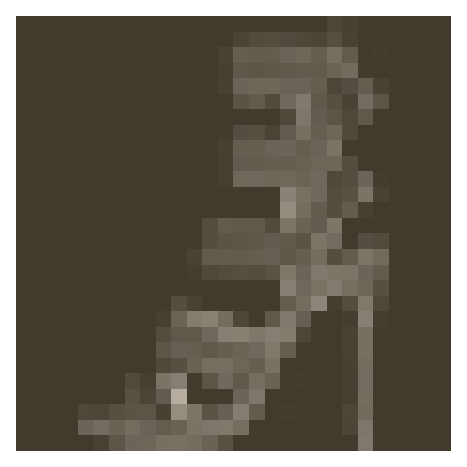

In [4]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:])

# Train a network

In [5]:
# Create the network, define the criterion
# and optimizer

model = fc_model.Network(784, 
                         10, 
                         [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001)

In [6]:
fc_model.train(model, trainloader, testloader, 
               criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.738..  Test Loss: 1.000..  Test Accuracy: 0.642
Epoch: 1/2..  Training Loss: 1.021..  Test Loss: 0.744..  Test Accuracy: 0.719
Epoch: 1/2..  Training Loss: 0.863..  Test Loss: 0.692..  Test Accuracy: 0.739
Epoch: 1/2..  Training Loss: 0.841..  Test Loss: 0.637..  Test Accuracy: 0.752
Epoch: 1/2..  Training Loss: 0.765..  Test Loss: 0.631..  Test Accuracy: 0.756
Epoch: 1/2..  Training Loss: 0.731..  Test Loss: 0.599..  Test Accuracy: 0.773
Epoch: 1/2..  Training Loss: 0.703..  Test Loss: 0.597..  Test Accuracy: 0.778
Epoch: 1/2..  Training Loss: 0.647..  Test Loss: 0.567..  Test Accuracy: 0.786
Epoch: 1/2..  Training Loss: 0.683..  Test Loss: 0.551..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.665..  Test Loss: 0.553..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.622..  Test Loss: 0.559..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.603..  Test Loss: 0.532..  Test Accuracy: 0.801
Epoch: 1/2..  Training Loss: 0.629..  Test Loss: 0.5

# Saving and loading networks

The parameters for PyTorch networks are stored in a model's *state_dict*.

In [7]:
print('Our model: \n\n', model, '\n')
print('The state dict keys: \n\n', 
              model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


We can save the state dict with *torch.save*.

In [8]:
torch.save(model.state_dict(), 'checkpoint.pth')

Then we can load the state dict with *torch.load*

In [9]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


To load the state dick in to the network, we do *model.load_state_dict(state_dict)*

In [10]:
model.load_state_dict(state_dict)

<All keys matched successfully>

**Important!**

Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture.

In [11]:
# For example
model = fc_model.Network(784, 10, [400, 200, 100])
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be save in the checkpoint, along with the state dict. So, we build a dictionary with all the information we need to completely rebuild the model.

In [12]:
checkpoint = {'input_size': 784, 
              'output_size': 10, 
              'hidden_layers' : [each.out_features for each in model.hidden_layers],
              'state_dict' : model.state_dict()
             }

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoints has all the necessary information to rebuild the trained model. We can write a function to load checkpoints.

In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(
                    checkpoint['input_size'], 
                    checkpoint['output_size'],
                    checkpoint['hidden_layers']
            )
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [14]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
